In [1]:
import numpy as np
import pandas as pd
import os
import time
import pickle
import gzip

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
%matplotlib inline

from sklearn.metrics import accuracy_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Fashion MNIST dataset
- 28*28 pixels(784 차원)
- label
  - 0 T-shirt/top
  - 1 Trouser
  - 2 Pullover
  - 3 Dress
  - 4 Coat
  - 5 Sandal
  - 6 Shirt
  - 7 Sneaker
  - 8 Bag
  - 9 Ankle boot


In [3]:
#데이터 불러오기
fashion=pd.read_csv('/content/drive/MyDrive/DSL/정규 1세션(ML)/[0207] Dimensionality_Reduction/fashion-mnist.csv') #경로수정
fashion.head(3) #60000 rows

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0


- (Q1) X_train, y_train, X_test, y_test 지정하기
  - 60000개의 전체 데이터셋 사용하지 않아도 됨 (학습 속도가 느려짐)
  - 본인이 생각하는 적절한 train 개수, test 개수를 설정하여 분리하도록
    - 이때 train과 test 데이터의 라벨 분포가 균등하게 이루어지도록 분리해야함(학습시에 편향되지 않도록)
    - 그래프 그려서 라벨값 분포가 균등한지 확인할 것

In [4]:
# 'label'을 y_label로, 나머지를 X_features로 할당

X_features = fashion.drop(['label'], axis = 1)
y_label = fashion.loc[:, 'label']

X_features

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,5,0,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,1,2,0,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,0,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,0,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


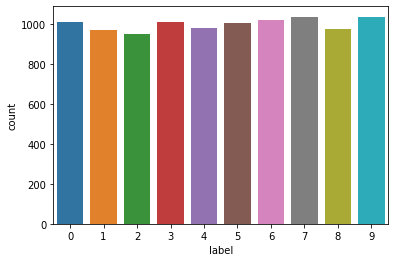

In [5]:
# train dataset으로 10000개 사용, y label이 균등하게 분포하는지 확인

X_train = X_features.loc[:9999, :]
y_train = y_label[:10000]

sns.countplot(y_train)
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


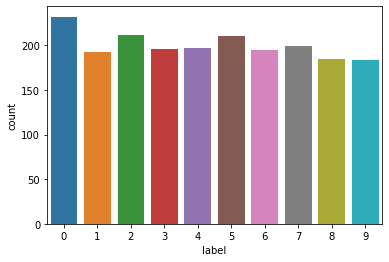

In [6]:
# test dataset으로 2000개 사용, y label이 균등하게 분포하는지 확인

X_test = X_features.loc[15000:16999, :]
y_test = y_label[15000:17000]

sns.countplot(y_test)
plt.show()

In [7]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(10000, 784) (10000,) (2000, 784) (2000,)


- 어떻게 생긴 데이터셋인지 확인해보기

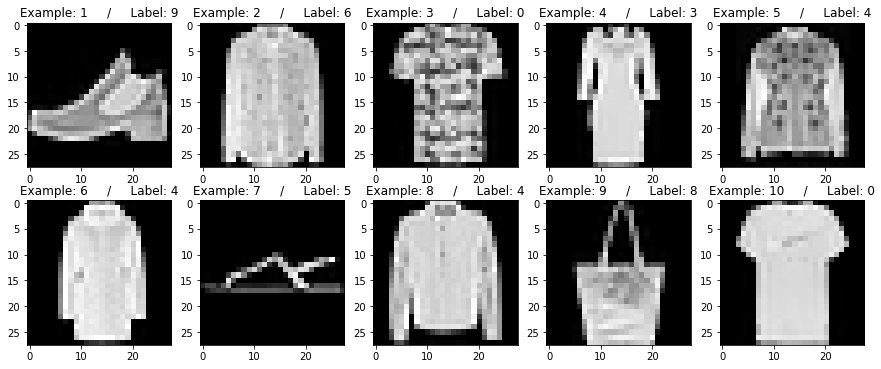

In [8]:
plt.figure(figsize=(15,6))
for i in range(1,11):
  plt.subplot(2,5,i)
  label = y_train.loc[i]
  image = X_train.loc[i,:].values.reshape([28, 28])
  plt.imshow(image, cmap=plt.get_cmap('gray'))
  plt.title('Example: %d     /     Label: %d'%(i, label))

plt.show()

# PCA를 활용해 성능 높여보기


- (Q2) 합리적인 잠재변수 개수 설정하기
  - PCA에서 각 잠재변수가 설명하는 분산 비율을 보고 적절한 잠재변수 개수 설정
  - 개수 설정 기준은 본인 재량. 다만, 명확한 기준을 서술할 것.

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 784)
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA.shape

(10000, 784)

In [10]:
# 첫 번째 주성분부터 10번째 주성분까지 각각의 주성분이 설명하는 분산은 어떻게 되는가?
# 목표: 설명하는 분산의 양이 80%를 

pca.explained_variance_ratio_[:10]

array([0.2912518 , 0.17484926, 0.06085366, 0.05086107, 0.03783416,
       0.03483235, 0.02289647, 0.01974233, 0.01335667, 0.01306534])

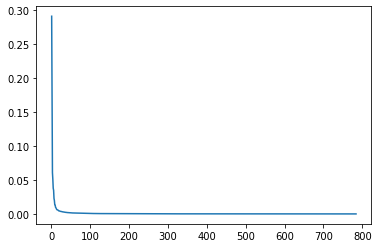

In [11]:
# 첫 번째 주성분부터 784번째 주성분까지 각각의 주성분이 설명하는 분산에 대한 그래프

plt.plot(range(1, 785), pca.explained_variance_ratio_)
plt.show()

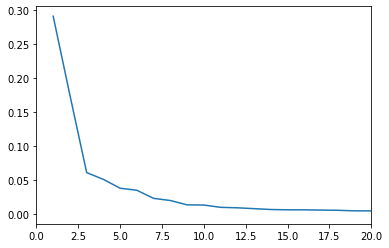

In [12]:
plt.plot(range(1, 785), pca.explained_variance_ratio_)
plt.xlim(0, 20)
plt.show()

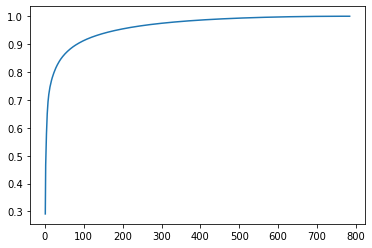

In [13]:
cumulative = []
temp = 0
for i in range(0, 784):
    temp += pca.explained_variance_ratio_[i]
    cumulative.append(temp)

plt.plot(range(1,785),cumulative)
plt.show()

In [14]:
for i in [10,20,50,100,784]:
  explained=np.sum(pca.explained_variance_ratio_[:i])
  print(i,'개의 잠재변수가 설명하는 분산은 전체 데이터의 {:.2f}%'.format(explained*100))

10 개의 잠재변수가 설명하는 분산은 전체 데이터의 71.95%
20 개의 잠재변수가 설명하는 분산은 전체 데이터의 78.47%
50 개의 잠재변수가 설명하는 분산은 전체 데이터의 86.26%
100 개의 잠재변수가 설명하는 분산은 전체 데이터의 91.29%
784 개의 잠재변수가 설명하는 분산은 전체 데이터의 100.00%


In [15]:
# 설명하는 분산의 양이 80%를 넘어가는 첫 번째 주성분 인덱스

cumulative=np.array(cumulative)
np.where(cumulative > 0.8)[0][0] # 23개 쓰면 분산의 80% 이상을 설명

23

- (Q3) 학습속도, 성능의 향상을 보이는지 확인
  - 기존에 배웠던 여러가지 classification model들 활용하기
  - 최소한 1가지 이상의 모델에 대해 비교해보고 차원축소 이전, 이후 어떠한 차이를 보이는지 서술


In [16]:
# PCA를 통한 특징 추출 과정에서는 y라벨을 사용하지 X(unsupervised)
# 성능 확인 과정에서 y라벨이 사용됨

pca = PCA(n_components = 23)
X_train_PCA = pca.fit_transform(X_train) # train은 fit + transform
X_test_PCA = pca.transform(X_test)       # test는 transform
print('Original space:',X_train.shape)
print('After PCA:',X_train_PCA.shape)

Original space: (10000, 784)
After PCA: (10000, 23)


### 1. Logistic Regression

In [17]:
# 차원축소 이전(origianl 공간 784차원)

start = time.time()
logistic_original = LogisticRegression(max_iter=1000) #warning 메시지가 나와서 max_iter 지정해줌
logistic_original.fit(X_train, y_train)  #train set만 고려
print('train accuracy:',accuracy_score(y_train, logistic_original.predict(X_train)))
print('test accuracy:',accuracy_score(y_test, logistic_original.predict(X_test)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 0.976
test accuracy: 0.785
117.4717sec


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
# 차원축소 이후(23차원)

start = time.time()
logistic_pca = LogisticRegression(max_iter = 1000) 
logistic_pca.fit(X_train_PCA, y_train)
print('train accuracy:',accuracy_score(y_train, logistic_pca.predict(X_train_PCA)))
print('test accuracy:',accuracy_score(y_test, logistic_pca.predict(X_test_PCA)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 0.8182
test accuracy: 0.81
22.9048sec


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Logistic Regression**

* PCA 이후 학습 속도 개선
* test accuracy 향상
* train accuracy는 감소했으나, 차원축소 전 train accuracy가 지나치게 높아 과적합이 우려된다는 점을 고려했을 때, 차원축소가 유리하게 작용할 것으로 보임.

### 2. Random Forest

In [19]:
# 차원축소 이전(origianl 공간 784차원)

start = time.time()
rf_original = RandomForestClassifier()
rf_original.fit(X_train, y_train)
print('train accuracy:',accuracy_score(y_train, rf_original.predict(X_train)))
print('test accuracy:',accuracy_score(y_test, rf_original.predict(X_test)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 1.0
test accuracy: 0.8515
17.3510sec


In [20]:
# 차원축소 이후(23차원)

start = time.time()
rf_pca = RandomForestClassifier()
rf_pca.fit(X_train_PCA, y_train)
print('train accuracy:',accuracy_score(y_train, rf_pca.predict(X_train_PCA)))
print('test accuracy:',accuracy_score(y_test, rf_pca.predict(X_test_PCA)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 1.0
test accuracy: 0.8365
5.7975sec


**Random Forest**

* PCA 이후 학습 속도 약간 개선되나, Random Forest는 원래도 병렬적 학습을 진행하는 기법이기 때문에 드라마틱한 변화는 일어나지 않음.
* test accuracy 약간 감소
* Random Forest의 경우 decision tree를 병렬적으로 여러 개 사용함으로써 decision tree 단일 사용 시 발생할 수 있는 과적합 문제를 자체적으로 해결하려고 노력한 기법이기 때문에, PCA 전후로 train accuracy의 변화는 없으나, 이미 과적합이 일어난 듯한 모습을 볼 수 있음.

### 3. XGBoost

In [21]:
# 차원축소 이전(origianl 공간 784차원)

from xgboost import XGBClassifier
start = time.time()
xgboost_original = XGBClassifier()
xgboost_original.fit(X_train, y_train)
print('train accuracy:',accuracy_score(y_train, xgboost_original.predict(X_train)))
print('test accuracy:',accuracy_score(y_test, xgboost_original.predict(X_test)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 0.9241
test accuracy: 0.849
252.9253sec


In [22]:
# 차원축소 이후(23차원)

start = time.time()
xgboost_pca = XGBClassifier()
xgboost_pca.fit(X_train_PCA, y_train)
print('train accuracy:',accuracy_score(y_train, xgboost_pca.predict(X_train_PCA)))
print('test accuracy:',accuracy_score(y_test, xgboost_pca.predict(X_test_PCA)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 0.872
test accuracy: 0.82
18.7039sec


**XGBoost**

* PCA 이후 학습 속도 크게 개선
* test accuracy, train accuracy 다소 감소

# 2차원으로 시각화
- (Q4) 여러가지 차원 축소 방법 중 적절할 것으로 예상되는 방법 최소한 3가지 이용해서 시각화해보기
  - 하나의 차원 축소 방법도 하이퍼파라미터의 설정 다양하게 해보기
  - ex) KPCA에서 다양한 커널 함수 사용, ISOMAP or LLE에서 고려할 이웃의 개수 변경해보기

### 1. PCA
* 분산을 크게 하는 잠재변수를 찾자!

In [23]:
# PCA를 통해 2차원으로 차원축소

start = time.time()
pca = PCA(n_components=2)
X_train_PCA = pca.fit_transform(X_train) 
print(f'{time.time()-start:.4f}sec')

0.9830sec


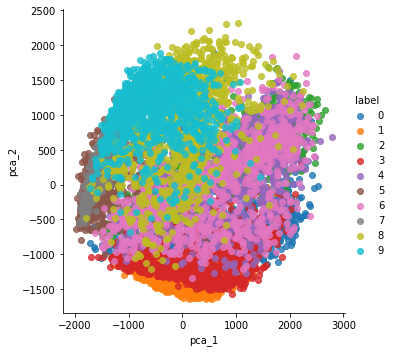

In [24]:
X_train_pca=pd.DataFrame(X_train_PCA).loc[:,0:1]
X_train_pca=pd.concat((X_train_pca, y_train), axis=1) 
X_train_pca.columns=['pca_1', 'pca_2', 'label']

sns.lmplot(x='pca_1',y='pca_2',data=X_train_pca,hue='label',fit_reg=False)
plt.show()

### 2. MDS
* 고차원에서의 거리 정보를 최대한 유지하는 저차원의 공간을 찾자!

In [ ]:
# 해보고 싶었는데 출력이 과도하게 오래 걸려서 일시중지했습니다...ㅠㅠ

from sklearn.manifold import MDS

start = time.time()
mds = MDS(n_components=2, random_state=42)
X_train_mds = mds.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

In [ ]:
X_train_mds = pd.DataFrame(X_train_mds).loc[:,0:1]
X_train_mds = pd.concat((X_train_mds, y_train), axis=1) 
X_train_mds.columns = ['mds_1', 'mds_2', 'label']
X_train_mds

sns.lmplot(x='mds_1',y='mds_2',data=X_train_mds,hue='label',fit_reg=False)
plt.show()

### 3. LDA
* class(label)을 잘 구분해주는 축을 찾자!

In [25]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

start = time.time()
lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(X_train, y_train) # 차원축소 과정에 y라벨값이 필요!
print(f'{time.time()-start:.4f}sec')

3.2213sec


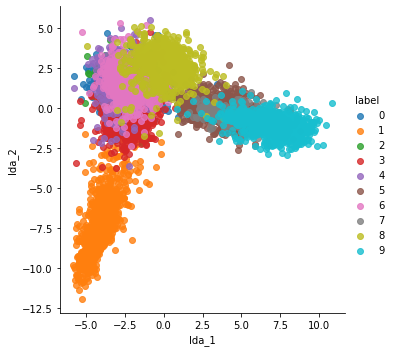

In [26]:
X_train_lda=pd.DataFrame(X_train_lda).loc[:,0:1]
X_train_lda=pd.concat((X_train_lda, y_train), axis=1) 
X_train_lda.columns=['lda_1', 'lda_2', 'label']
X_train_lda

sns.lmplot(x='lda_1',y='lda_2',data=X_train_lda,hue='label',fit_reg=False)
plt.show()

### 4. KPCA
* 고차원에서 분산을 크게 해주는 축을 찾자!
* 데이터의 형태에 따라 적절한 커널 및 하이퍼파라미터를 선택해줄 필요가 있다

In [27]:
from sklearn.decomposition import KernelPCA

# kernel로 Radial Basis Function(RBF, 다른 말로는 Gaussian) 사용

start = time.time()
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True) #방사형 커널 사용
X_train_rbf_pca=rbf_pca.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

63.5610sec


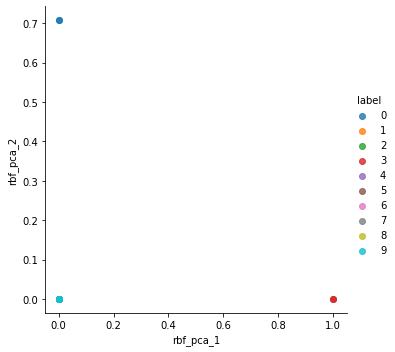

In [28]:
X_train_rbf_pca = pd.DataFrame(X_train_rbf_pca).loc[:,0:1]
X_train_rbf_pca = pd.concat((X_train_rbf_pca, y_train), axis=1) 
X_train_rbf_pca.columns = ['rbf_pca_1', 'rbf_pca_2', 'label']

sns.lmplot(x='rbf_pca_1',y='rbf_pca_2',data=X_train_rbf_pca,hue='label',fit_reg=False)
plt.show()

In [29]:
# kernel로 sigmoid 사용

start = time.time()
sig_pca = KernelPCA(n_components=2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True) #시그모이드 커널 사용
X_train_sig_pca=sig_pca.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

49.8543sec


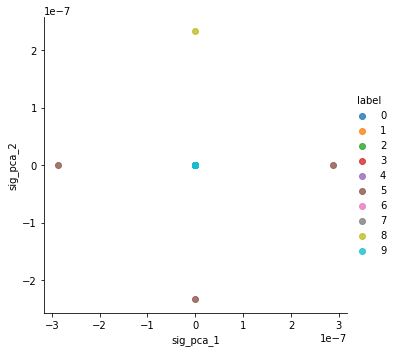

In [30]:
X_train_sig_pca = pd.DataFrame(X_train_sig_pca).loc[:,0:1]
X_train_sig_pca = pd.concat((X_train_sig_pca, y_train), axis=1) 
X_train_sig_pca.columns = ['sig_pca_1', 'sig_pca_2', 'label']

sns.lmplot(x='sig_pca_1',y='sig_pca_2',data=X_train_sig_pca,hue='label',fit_reg=False)
plt.show()

### 5. ISOMAP
* 지오데식 거리를 최대한 보존하는 저차원의 공간을 찾자!

In [31]:
from sklearn.manifold import Isomap

start = time.time()
isomap = Isomap(n_neighbors=5, n_components=2, n_jobs=4)         
X_train_isomap = isomap.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

90.3927sec


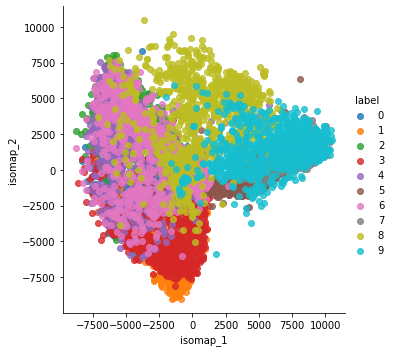

In [32]:
X_train_isomap=pd.DataFrame(X_train_isomap).loc[:,0:1]
X_train_isomap=pd.concat((X_train_isomap, y_train), axis=1) 
X_train_isomap.columns=['isomap_1', 'isomap_2', 'label']

sns.lmplot(x='isomap_1',y='isomap_2',data=X_train_isomap,hue='label',fit_reg=False)
plt.show()

### 6. LLE
* 주변 이웃들의 관계를 저차원에서도 그대로 유지하는 저차원 공간을 찾자!

In [33]:
from sklearn.manifold import LocallyLinearEmbedding

start = time.time()
lle = LocallyLinearEmbedding(n_components=2, random_state=42)
X_train_lle = lle.fit_transform(X_train)
#X_test_lle=lle.transform(X_test)
print(f'{time.time()-start:.4f}sec')

8.7746sec


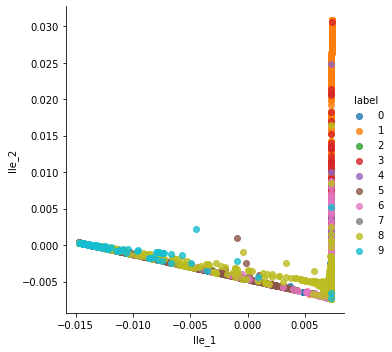

In [34]:
X_train_lle = pd.DataFrame(X_train_lle).loc[:,0:1]
X_train_lle = pd.concat((X_train_lle, y_train), axis=1) 
X_train_lle.columns = ['lle_1', 'lle_2', 'label']
X_train_lle

sns.lmplot(x='lle_1',y='lle_2',data=X_train_lle,hue='label',fit_reg=False)
plt.show()

### 7. t-SNE
* 주변 이웃들과의 확률적 관계를 그대로 유지해주는 저차원의 공간을 찾자!

In [35]:
from sklearn.manifold import TSNE

start = time.time()
tsne = TSNE(n_components=2, random_state=42) #4미만의 공간으로
X_train_tsne = tsne.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


99.5773sec


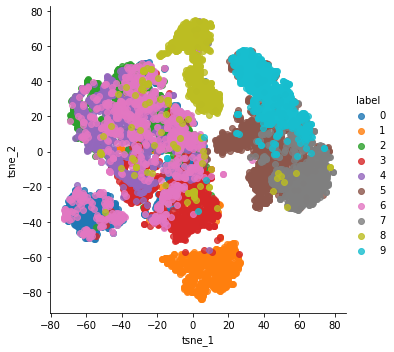

In [36]:
X_train_tsne = pd.DataFrame(X_train_tsne).loc[:,0:1]
X_train_tsne = pd.concat((X_train_tsne, y_train), axis=1) 
X_train_tsne.columns = ['tsne_1', 'tsne_2', 'label']
X_train_tsne

sns.lmplot(x='tsne_1',y='tsne_2',data=X_train_tsne,hue='label',fit_reg=False)
plt.show()

- (Q5) 시도해본 차원축소 방법 중 Fashion MNIST 데이터셋을 가장 잘 시각화하는 것으로 보이는 방법은 무엇인지 서술해보자.  
> -> t-SNE. 784차원을 2차원으로 시각화했음을 고려해보면 굉장히 좋은 시각화 결과를 보여주고 있다. 각 라벨별로 클러스터가 잘 나뉜 경우가 많고, 특히 1, 8번 라벨에 대해 효과적으로 군집을 형성하여 구별해주고 있다.


- (Q6) 저차원에서 제대로 분류가 잘 되지 않는 라벨은 무엇인지 언급해보고, 왜 제대로 분류되지 않을 것인지 추측해보자.  
> -> 어느 정도 시각화다운 시각화가 이루어진 PCA, LDA, ISOMAP, t-SNE를 기준으로 볼 때, 0, 2, 3, 4, 5, 6 라벨의 경우 저차원에서 제대로 분류가 되지 않는 모습을 볼 수 있었다. 차원축소 과정에서 해당 라벨들을 구분하는 데 주요한 기여를 하던 피처들이 사라지거나 그 영향력이 약화되었기 때문에 해당 라벨들이 저차원에서는 분류가 잘 되지 않는 것이 아닐까 추측한다.

수고하셨습니다~